# The Proposed DML Approach 
In this notebook, we describe the training and validation process of the proposed DML models

## 1. Importing Necessary Libraries

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, GRU, BatchNormalization, concatenate, Attention, Permute
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1, L2
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Reading the Training/Validation Datasets

In [2]:
train = "./data/train.csv"
val = "./data/val.csv"
train_df = pd.read_csv(train)
val_df = pd.read_csv(val)

In [3]:
x_train = train_df.drop(columns=['label'])
x0_train = train_df[['CreationTime','ArrivalTime','RealId','Pseudonym','receiverId','receiverPseudo','Accel_x','Accel_y','Heading_x','Heading_y','Pos_x','Pos_y','Speed_x','Speed_y']]
x1_train = train_df.drop(columns=['CreationTime','ArrivalTime','RealId','Pseudonym','receiverId','receiverPseudo','Accel_x','Accel_y','Heading_x','Heading_y','Pos_x','Pos_y','Speed_x','Speed_y','label'])
y_train = train_df['label']

In [4]:
x_val = val_df.drop(columns=['label'])
x0_val = val_df[['CreationTime','ArrivalTime','RealId','Pseudonym','receiverId','receiverPseudo','Accel_x','Accel_y','Heading_x','Heading_y','Pos_x','Pos_y','Speed_x','Speed_y']]
x1_val = val_df.drop(columns=['CreationTime','ArrivalTime','RealId','Pseudonym','receiverId','receiverPseudo','Accel_x','Accel_y','Heading_x','Heading_y','Pos_x','Pos_y','Speed_x','Speed_y','label'])
y_val = val_df['label']

## 3. Generating the Sequences
In our study, we consider two cases:
- Generating only the BSMs as sequences.
- Generating the whole data (BSMs and their plausibility checks) as sequences.

In [5]:
window_size = 20

# Function to create overlapping windows
def create_overlapping_windows(data, window_size):
  sequences = []
  total_iterations = len(data) - window_size + 1
  with tqdm(total=total_iterations) as pbar:
        for i in range(total_iterations):
            sequences.append(data[i:i+window_size])
            pbar.update(1)  # Update progress bar
  return np.array(sequences)

- Train Data: Generating the whole data (BSMs and their plausibility checks) as sequences.

In [6]:
x_train_windows = create_overlapping_windows(x_train, window_size)
print(x_train_windows.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799981/799981 [00:24<00:00, 32651.03it/s]


(799981, 20, 50)


- Train Data: Generating only the BSMs as sequences.

In [7]:
x0_train_windows = create_overlapping_windows(x0_train, window_size)
print(x0_train_windows.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799981/799981 [00:22<00:00, 36022.18it/s]


(799981, 20, 14)


- Validation Data: Generating the whole data (BSMs and their plausibility checks) as sequences.

In [8]:
x_val_windows = create_overlapping_windows(x_val, window_size)
print(x_val_windows.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199981/199981 [00:04<00:00, 41903.93it/s]


(199981, 20, 50)


- Validation Data: Generating only the BSMs as sequences.

In [9]:
x0_val_windows = create_overlapping_windows(x0_val, window_size)
print(x0_val_windows.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199981/199981 [00:06<00:00, 31024.52it/s]


(199981, 20, 14)


## 4. One-hot Encoding

We apply a manual one-hot encoding method for the `label` (class).

In [10]:
mapping = {0: 0, 13: 1, 14: 2, 15: 3, 18: 4, 19: 5}

# Number of classes
num_classes = len(mapping)
# Convert labels to one-hot encoding with the correct number of classes
y_train_encoded = np.zeros((len(y_train), num_classes))

# Convert labels to one-hot encoding using the provided mapping
for i, class_index in enumerate(y_train):
    mapped_class_index = mapping[class_index]
    y_train_encoded[i, mapped_class_index] = 1

print(y_train_encoded.shape)

(800000, 6)


In [11]:
mapping = {0: 0, 13: 1, 14: 2, 15: 3, 18: 4, 19: 5}

# Number of classes
num_classes = len(mapping)
# Convert labels to one-hot encoding with the correct number of classes
y_val_encoded = np.zeros((len(y_val), num_classes))

# Convert labels to one-hot encoding using the provided mapping
for i, class_index in enumerate(y_val):
    mapped_class_index = mapping[class_index]
    y_val_encoded[i, mapped_class_index] = 1

print(y_val_encoded.shape)

(200000, 6)


## 5. Deep Adaptive Input Normalization (DAIN) Layer

For the normalization method, we apply the Deep Adaptive Input Normalization (DAIN) layer as the best practice for time series data.

In [12]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
class Adaptive_Normalizer_Layer(tf.keras.layers.Layer):
    def __init__(self, mode = 'full', input_dim = 5):
        super(Adaptive_Normalizer_Layer, self).__init__()
        
        '''
        PARAMETERS
        
        :param mode: Type of normalization to be performed.
                        - 'adaptive_average' performs the adaptive average of the inputs
                        - 'adaptive_scale' performs the adaptive z-score normalization of the inputs
                        - 'full' (Default) performs the complete normalization process: adaptive_average + adaptive_scale + gating
        :param input_dim: Number of rows in each batch
        '''
        
        self.mode = mode
        self.x = None

        self.eps = 1e-8
        
        initializer = tf.keras.initializers.Identity()
        gate_initializer =  tf.keras.initializers.GlorotNormal()
        bias_initializer = tf.keras.initializers.RandomNormal()
        self.linear_1 = tf.keras.layers.Dense(input_dim, kernel_initializer=initializer, use_bias=False)
        self.linear_2 = tf.keras.layers.Dense(input_dim, kernel_initializer=initializer, use_bias=False)
        self.linear_3 = tf.keras.layers.Dense(input_dim, kernel_initializer=gate_initializer, bias_initializer=gate_initializer)

    def call(self, inputs):
        # Expecting (n_samples, dim, n_feature_vectors)
        
        def adaptive_avg(inputs):
        
            avg = tf.keras.backend.mean(inputs, 2)
            adaptive_avg = self.linear_1(avg)
            adaptive_avg = tf.keras.backend.reshape(adaptive_avg, (tf.shape(inputs)[0].numpy(), tf.shape(inputs)[1].numpy(), 1))
            x = inputs - adaptive_avg
            
            return x
        
        def adaptive_std(x):
        
            std = tf.keras.backend.mean(x ** 2, 2)
            std = tf.keras.backend.sqrt(std + self.eps)
            adaptive_std = self.linear_2(std)
            adaptive_std = tf.where(tf.math.less_equal(adaptive_std, self.eps), 1, adaptive_std)
            adaptive_std = tf.keras.backend.reshape(adaptive_std, (tf.shape(inputs)[0].numpy(), tf.shape(inputs)[1].numpy(), 1))
            x = x / (adaptive_std)
            
            return x
        
        def gating(x):
            
            gate = tf.keras.backend.mean(x, 2)
            gate = self.linear_3(gate)
            gate = tf.math.sigmoid(gate)
            gate = tf.keras.backend.reshape(gate, (tf.shape(inputs)[0].numpy(), tf.shape(inputs)[1].numpy(), 1))
            x = x * gate
            
            return x
        
        if self.mode == None:
            pass
        
        elif self.mode == 'adaptive_average':
            self.x = adaptive_avg(inputs)
            
        elif self.mode == 'adaptive_scale':
            self.x = adaptive_avg(inputs)
            self.x = adaptive_std(x)
            
        elif self.mode == 'full':
            self.x = adaptive_avg(inputs)
            self.x = adaptive_std(self.x)
            self.x = gating(self.x)
        
        else:
            assert False

        return self.x

## 6. Training/Validation Process
To demonstrate the performance of the proposed architecture during training and validation, we compare it with two other architectures as follows:

- Architecture 1: LSTM-Dense-GRU with only BSMs sequences as input (without adding the plausibility checks data)

In [13]:
# Define the input layer
input_layer = Input(shape=(20, 14))

# Build the model using the input
x = Bidirectional(LSTM(23, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dense(23, activation='relu')(x)
x = BatchNormalization()(x)
x = GRU(12, return_sequences=False)(x)
x = BatchNormalization()(x)
output_layer = Dense(6, activation='softmax')(x)

# Create the model
model1 = Model(inputs=input_layer, outputs=output_layer)

# Define the learning rate
learning_rate = 0.001  # Adjust the learning rate as needed

# Compile the model with Adam optimizer and specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 46)         │         6,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 46)         │           184 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 23)         │         1,081 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 23)         │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 12)             │         1,332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,807 (76.62 KB)

 Trainable params: 9,645 (75.35 KB)

 Non-trainable params: 162 (1.27 KB)

In [14]:
normalizer_layer = Adaptive_Normalizer_Layer(mode='full', input_dim=14)
data = tf.transpose(x0_train_windows, perm=[0, 2, 1])
x0_train_normalizd = normalizer_layer(data)
x0_train_normalizd = tf.transpose(x0_train_normalizd, perm=[0, 2, 1])
x0_train_normalizd.shape

TensorShape([799981, 20, 14])

In [15]:
data = tf.transpose(x0_val_windows, perm=[0, 2, 1])
x0_val_normalizd = normalizer_layer(data)
x0_val_normalizd = tf.transpose(x0_val_normalizd, perm=[0, 2, 1])
x0_val_normalizd.shape

TensorShape([199981, 20, 14])

In [16]:
y_train_encoded_matched = y_train_encoded[:len(x0_train_normalizd)]

y_val_encoded_matched = y_val_encoded[:len(x0_val_normalizd)]

In [17]:
# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")

# Train the model with EarlyStopping callback
history1 = model1.fit(x0_train_normalizd, y_train_encoded_matched, epochs=20, batch_size=128,  validation_data=(x0_val_normalizd, y_val_encoded_matched), callbacks=[early_stopping_callback])

Epoch 1/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 188s 29ms/step - accuracy: 0.4277 - loss: 1.3328 - val_accuracy: 0.4745 - val_loss: 1.1316
Epoch 2/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 202s 29ms/step - accuracy: 0.5528 - loss: 1.0252 - val_accuracy: 0.4676 - val_loss: 1.1640
Epoch 3/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 203s 30ms/step - accuracy: 0.5916 - loss: 0.9577 - val_accuracy: 0.4752 - val_loss: 1.1560
Epoch 4/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 189s 30ms/step - accuracy: 0.6139 - loss: 0.9144 - val_accuracy: 0.4826 - val_loss: 1.1725


- Architecture 2: LSTM-Dense-GRU with BSMs and plausibility checks data as sequences

In [18]:
# Define the input layer
input_layer = Input(shape=(20, 50))

# Build the model using the input
x = Bidirectional(LSTM(23, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dense(23, activation='relu')(x)
x = BatchNormalization()(x)
x = GRU(12, return_sequences=False)(x)
x = BatchNormalization()(x)
output_layer = Dense(6, activation='softmax')(x)

# Create the model
model2 = Model(inputs=input_layer, outputs=output_layer)

# Define the learning rate
learning_rate = 0.001  # Adjust the learning rate as needed

# Compile the model with Adam optimizer and specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 20, 46)         │        13,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 46)         │           184 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 23)         │         1,081 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 23)         │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 12)             │         1,332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,431 (128.37 KB)

 Trainable params: 16,269 (127.10 KB)

 Non-trainable params: 162 (1.27 KB)

In [19]:
normalizer_layer = Adaptive_Normalizer_Layer(mode='full', input_dim=50)
data = tf.transpose(x_train_windows, perm=[0, 2, 1])
x_train_normalizd = normalizer_layer(data)
x_train_normalizd = tf.transpose(x_train_normalizd, perm=[0, 2, 1])
x_train_normalizd.shape

2024-07-08 08:37:04.625468: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6399848000 exceeds 10% of free system memory.
2024-07-08 08:37:09.789674: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6399848000 exceeds 10% of free system memory.
2024-07-08 08:37:11.612473: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6399848000 exceeds 10% of free system memory.
2024-07-08 08:37:12.715589: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6399848000 exceeds 10% of free system memory.
2024-07-08 08:37:27.281256: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6399848000 exceeds 10% of free system memory.


TensorShape([799981, 20, 50])

In [20]:
data = tf.transpose(x_val_windows, perm=[0, 2, 1])
x_val_normalizd = normalizer_layer(data)
x_val_normalizd = tf.transpose(x_val_normalizd, perm=[0, 2, 1])
x_val_normalizd.shape

TensorShape([199981, 20, 50])

In [21]:
y_train_encoded_matched = y_train_encoded[:len(x_train_normalizd)]

y_val_encoded_matched = y_val_encoded[:len(x_val_normalizd)]

In [22]:
# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")

# Train the model with EarlyStopping callback
history2 = model2.fit(x_train_normalizd, y_train_encoded_matched, epochs=20, batch_size=128,  validation_data=(x_val_normalizd, y_val_encoded_matched), callbacks=[early_stopping_callback])

Epoch 1/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 194s 30ms/step - accuracy: 0.7601 - loss: 0.6167 - val_accuracy: 0.8822 - val_loss: 0.3068
Epoch 2/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 190s 30ms/step - accuracy: 0.9271 - loss: 0.1879 - val_accuracy: 0.8780 - val_loss: 0.3300
Epoch 3/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 202s 31ms/step - accuracy: 0.9405 - loss: 0.1552 - val_accuracy: 0.8830 - val_loss: 0.3243
Epoch 4/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 188s 30ms/step - accuracy: 0.9474 - loss: 0.1386 - val_accuracy: 0.8841 - val_loss: 0.3264


- Architecture 3: Proposed DML architecture with BSMs and plausibility data as sequences in a Multi-modal architecture (two branches: an LSTM-Dense-GRU with attention mechanism branch for processing the BSMs messages as time-series data, and an MLP branch for handling the plausibility checks as extra features).

In [42]:
# Define the input layers
input_lstm = Input(shape=(20, 14))
input_mlp = Input(shape=(36,)) 

# LSTM layers
x = Bidirectional(LSTM(23, return_sequences=True))(input_lstm)

# Attention layer
attention = Attention()([x, x])

gate = Dense(units=x.shape[-1], activation='sigmoid')(attention)
x = gate * x + (1 - gate) * attention
x = BatchNormalization()(x)

x = Dense(23, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(x)
x = BatchNormalization()(x)
x = GRU(12, return_sequences=False)(x)
x = BatchNormalization()(x)

# MLP layers
mlp_output = Dense(100, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(input_mlp)
mlp_output = BatchNormalization()(mlp_output)

# Concatenate LSTM and MLP outputs
combined_output = concatenate([x, mlp_output])
combined_output = Dense(24, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(combined_output)
combined_output = BatchNormalization()(combined_output)

output_layer = Dense(6, activation='softmax')(combined_output)

# Create the model
model3 = Model(inputs=[input_lstm, input_mlp], outputs=output_layer)

# Define the learning rate
learning_rate = 0.001 # Adjust the learning rate as needed

# Compile the model with Adam optimizer and specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 20, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 20, 46)    │      6,992 │ input_layer_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 20, 46)    │          0 │ bidirectional_5[… │
│ (Attention)         │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 20, 46)    │      2,162 │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 20, 46)    │          0 │ dense_34[0][0]    │
│ (Subtract)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 20, 46)    │          0 │ dense_34[0][0],   │
│ (Multiply)          │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 20, 46)    │          0 │ subtract_3[0][0], │
│ (Multiply)          │                   │            │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 46)    │          0 │ multiply_6[0][0], │
│                     │                   │            │ multiply_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 46)    │        184 │ add_3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 20, 23)    │      1,081 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 23)    │         92 │ dense_35[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 12)        │      1,332 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 100)       │      3,700 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12)        │         48 │ gru_5[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 112)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 24)        │      2,712 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,949 (148.04 KB)

 Trainable params: 18,539 (144.84 KB)

 Non-trainable params: 410 (3.20 KB)

In [38]:
x1_train_matched = x1_train[:len(x0_train_normalizd)]
y_train_encoded_matched = y_train_encoded[:len(x0_train_normalizd)]

x1_val_matched = x1_val[:len(x0_val_normalizd)]
y_val_encoded_matched = y_val_encoded[:len(x0_val_normalizd)]

- Initial Training Phase

In [43]:
# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")

# Train the model with EarlyStopping callback
history4 = model4.fit([x0_train_normalizd, x1_train_matched], y_train_encoded_matched, epochs=20, batch_size=128,  validation_data=([x0_val_normalizd, x1_val_matched], y_val_encoded_matched), callbacks=[early_stopping_callback])

Epoch 1/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 169s 42ms/step - accuracy: 0.8966 - loss: 0.2867 - val_accuracy: 0.9187 - val_loss: 0.2448
Epoch 2/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 163s 42ms/step - accuracy: 0.9522 - loss: 0.1268 - val_accuracy: 0.9043 - val_loss: 0.2630
Epoch 3/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 201s 41ms/step - accuracy: 0.9623 - loss: 0.1016 - val_accuracy: 0.9159 - val_loss: 0.2959
Epoch 4/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 160s 41ms/step - accuracy: 0.9677 - loss: 0.0879 - val_accuracy: 0.9062 - val_loss: 0.2743
Epoch 5/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 160s 41ms/step - accuracy: 0.9705 - loss: 0.0802 - val_accuracy: 0.8961 - val_loss: 0.3089
Epoch 6/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 161s 41ms/step - accuracy: 0.9728 - loss: 0.0740 - val_accuracy: 0.9002 - val_loss: 0.3122


- Self-Training Phase

In [44]:
# Convert Pandas DataFrames to NumPy arrays if needed
x1_val_matched_np = x1_val_matched.values if isinstance(x1_val_matched, pd.DataFrame) else x1_val_matched
y_val_encoded_matched_np = y_val_encoded_matched.values if isinstance(y_val_encoded_matched, pd.DataFrame) else y_val_encoded_matched

# Assuming outputval is already a TensorFlow tensor
x0_val_normalizd_np = x0_val_normalizd.numpy()

# Define the number of self-training iterations and confidence threshold
num_iterations = 5
confidence_threshold = 0.9

for i in range(num_iterations):
    # Step 2: Generate pseudo-labels for the validation data
    pseudo_labels = model3.predict([x0_val_normalizd, x1_val_matched])
    pseudo_confidences = np.max(pseudo_labels, axis=1)
    pseudo_classes = np.argmax(pseudo_labels, axis=1)
    # True classes
    true_classes = np.argmax(y_val_encoded_matched, axis=1)
    # Filter pseudo-labels based on confidence threshold
    high_confidence_indices = np.where((pseudo_confidences >= confidence_threshold) & (pseudo_classes == true_classes))[0]
    if len(high_confidence_indices) == 0:
        print(f"Iteration {i+1}: No high-confidence pseudo-labels found. Stopping early.")
        break

    high_confidence_pseudo_labels = pseudo_classes[high_confidence_indices]
    high_confidence_pseudo_labels_encoded = tf.keras.utils.to_categorical(high_confidence_pseudo_labels, num_classes=6)

    # Extract high-confidence pseudo-labeled data
    high_confidence_outputval = x0_val_normalizd_np[high_confidence_indices]
    high_confidence_x1val = x1_val_matched_np[high_confidence_indices]

    # Combine the original labeled data and the high-confidence pseudo-labeled data
    combined_output = np.concatenate((output, high_confidence_outputval), axis=0)
    combined_x1 = np.concatenate((x1_train_matched, high_confidence_x1val), axis=0)
    combined_labels = np.concatenate((y_train_encoded_matched, high_confidence_pseudo_labels_encoded), axis=0)

    # Step 4: Retrain the model using the combined dataset
    history_fine_tune = model3.fit(
        [combined_output, combined_x1],
        combined_labels,
        epochs=1,  # Adjust the number of epochs as needed
        batch_size=128,
        validation_data=([x0_val_normalizd, x1_val_matched], y_val_encoded_matched)
    )

    # Step 5: Evaluate the model on the validation data
    new_predictions = model3.predict([x0_val_normalizd, x1_val_matched])
    new_predicted_classes = np.argmax(new_predictions, axis=1)
    new_true_classes = np.argmax(y_val_encoded_matched, axis=1)

    # Calculate the number of misclassified instances
    misclassified_indices = np.where(new_predicted_classes != new_true_classes)[0]
    print(f"Iteration {i+1}: Number of misclassified instances: {len(misclassified_indices)}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step
162774
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 203s 39ms/step - accuracy: 0.9803 - loss: 0.0553 - val_accuracy: 0.9023 - val_loss: 0.3150
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step
Iteration 1: Number of misclassified instances: 19534
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step
164140
5189/5189 ━━━━━━━━━━━━━━━━━━━━ 208s 40ms/step - accuracy: 0.9813 - loss: 0.0524 - val_accuracy: 0.9244 - val_loss: 0.3076
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step
Iteration 2: Number of misclassified instances: 15127
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step
174645
5271/5271 ━━━━━━━━━━━━━━━━━━━━ 208s 39ms/step - accuracy: 0.9819 - loss: 0.0509 - val_accuracy: 0.9232 - val_loss: 0.3301
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step
Iteration 3: Number of misclassified instances: 15356
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step
175516
5278/5278 ━━━━━━━━━━━━━━━━━━━━ 209s 40ms/step - accuracy: 0.9824 - loss: 0.0486 - val_accuracy: 0.9292 - val_loss: 0.3031
6250/6250 ━━━━

- Comparaison

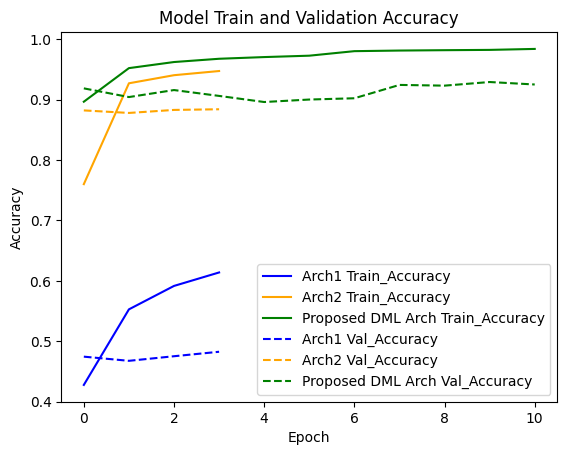

In [49]:
# Plot train accuracy
plt.plot(history1.history['accuracy'], label='Arch1 Train_Accuracy', color='blue')
plt.plot(history2.history['accuracy'], label='Arch2 Train_Accuracy', color='orange')
plt.plot(history3.history['accuracy'], label='Proposed DML Arch Train_Accuracy', color='green')

# Plot validation accuracy
plt.plot(history1.history['val_accuracy'], linestyle='--', label='Arch1 Val_Accuracy', color='blue')
plt.plot(history2.history['val_accuracy'], linestyle='--', label='Arch2 Val_Accuracy', color='orange')
plt.plot(history3.history['val_accuracy'], linestyle='--', label='Proposed DML Arch Val_Accuracy', color='green')

plt.title('Model Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

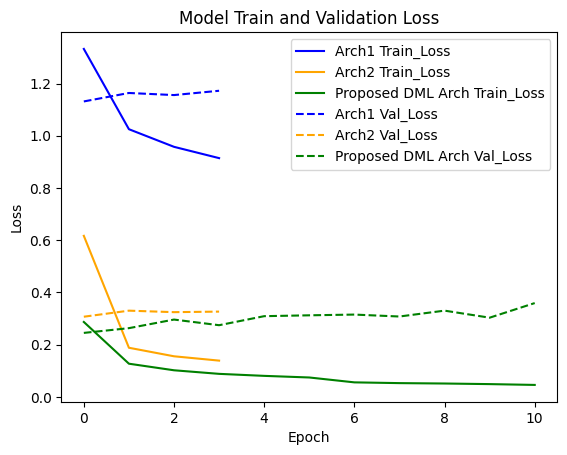

In [50]:
# Plot train accuracy
plt.plot(history1.history['loss'], label='Arch1 Train_Loss', color='blue')
plt.plot(history2.history['loss'], label='Arch2 Train_Loss', color='orange')
plt.plot(history3.history['loss'], label='Proposed DML Arch Train_Loss', color='green')

# Plot validation accuracy
plt.plot(history1.history['val_loss'], linestyle='--', label='Arch1 Val_Loss', color='blue')
plt.plot(history2.history['val_loss'], linestyle='--', label='Arch2 Val_Loss', color='orange')
plt.plot(history3.history['val_loss'], linestyle='--', label='Proposed DML Arch Val_Loss', color='green')

plt.title('Model Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()